In [18]:
import os, dotenv

dotenv.load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["COMPOSIO_API_KEY"] = os.getenv("COMPOSIO_API_KEY")

In [19]:
## Models
from langchain_google_genai import  ChatGoogleGenerativeAI
from langchain_groq import  ChatGroq

gemini_model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
llama_model = ChatGroq(model="llama-3.3-70b-versatile")
deepseek_model = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [20]:
from typing_extensions import TypedDict
from typing import Annotated, Literal

from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages

## State
class LinkedInGraphState(MessagesState):
    task: str
    critique: str
    post: str
    user_feedback: str
    llm_feedback: str
    context: list


In [21]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.types import Command, interrupt

tavily_tool = TavilySearchResults(max_results=5)

def web_search(state: LinkedInGraphState) -> Command[Literal["post_writer"]]:
    # results = tavily_tool.invoke(state['messages'])

    return Command(
        # state update
        update={"context": "results"},
        goto="post_writer"
    )

In [22]:
def post_writer(state: LinkedInGraphState)-> Command[Literal["post_analyzer"]]:
    
    return Command(
        update={"post": state['messages'][-1]},
        goto="post_analyzer"
    )

In [23]:
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage, AIMessage, ToolMessage, HumanMessage, AnyMessage

class PostAnalystSchema(BaseModel):
    next_node: Literal["post_writer", "upload_post"]
    feedback: str = Field(description="The feedback about the post.")

post_analyst_llm = llama_model.with_structured_output(PostAnalystSchema)

ANALYST_PROMPT = """You are a LinkedIn post analyst. Your task is to route the given post to either back to the post_writer or to upload_post nodes. 
If the given post is well-written according to the given example posts, route it upload_post node, so that it can be posted on LinkedIn.
If the post does not match the style of given example posts, route it back to the post_writer node along with the feedback so that it can improve
the post.

## Example Posts:

#### Example 1:
Software engineers who do not speak well 

or do not dress presentable will struggle.

If your MO is I am great technical talent and thats all that matters. 

Neglect the effort to communicate better or make an impression to stakeholders.

When Ai catches up to become a principal engineer, your worth diminishes.

Get good at talking to people, care about how you present your ideas and yourself.

Will make such a difference.
Agree?
---

#### Example 2:
CS STUDENTS: Snapchat is paying entry-level engineers in nyc $190k.

Snap isn’t paying $190k to test their “ar googles.”

Snap is paying $190k or even $500k so you can be part of the team that can help them make their next $100Bn in market cap.

Too many “talent” and potentially even “motivated” young engineers get all “hip hip hooray” after landing the TC (offer letter)…

without visualizing the bigger picture. Why do you exist? What does your team and director do? Which team/product line makes the most money? How do you make the company better?

Someone can argue if the purpose of your specific role as an engineer is opaque and the intrigue to better your technical organization is missing…

there might be diminishing returns on hiring such an engineer in the advent of ai. 

Thoughts?
---

#### Example 3:
NYC Hacker house meetup. 

This was how it went down.

1/ gather at the hacker house
2/ eat and vibe
3/ go to the office 

7 headstarter residents and mentor(google) and hiring manager at startup ($145mn series A) came. 

I gave folks a game plan on how to get a job, roasted resumes and everyone just vibes.

IRL is where its at. 

Who agrees? 

Run it back again?
"""

def post_analyzer(state: LinkedInGraphState) -> Command[Literal["upload_post", "post_writer"]]:
    
    post_analysis = post_analyst_llm.invoke([SystemMessage(content=ANALYST_PROMPT)] + [state["post"]])

    user_feedback = ""
    if post_analysis.next_node == "post_writer":
        goto = "post_writer"
        user_feedback = interrupt("Please provide feedback about the post:")

    elif post_analysis.next_node == "upload_post":
        goto = "upload_post"

    return Command(
        update={"llm_feedback": post_analysis.feedback, 
                "user_feedback": user_feedback
               },
        goto=goto
    )

In [24]:
def upload_post(state: LinkedInGraphState) -> Command[Literal["__end__"]]:
    
    return Command(
        update={"messages": [HumanMessage(content="The post has successfully been posted!")]},
        goto="__end__"
    )
    

### Task Router

In [25]:
def task_router(state: LinkedInGraphState) -> Literal["post_writer", "web_search"]:
    if state.get("feedback"):
        return "post_writer"
    return "web_search"

## Graph

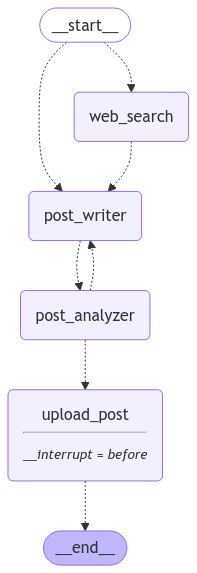

In [26]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from typing import TypedDict, Annotated
from IPython.display import Image, display

# Build graph
builder = StateGraph(LinkedInGraphState)

builder.add_node("post_writer", post_writer)
builder.add_node("web_search", web_search)
builder.add_node("post_analyzer", post_analyzer)
builder.add_node("upload_post", upload_post)

builder.add_conditional_edges(START, task_router)

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer, interrupt_before=["upload_post"])

## Display graph
display(Image(graph.get_graph().draw_mermaid_png()))


In [121]:
config = {"configurable": {"thread_id": "abc"}}

for event in graph.stream({"messages": [HumanMessage(content="""
East vs west war is crazy. 
Deepseek was a fine tuned llama model. 

Only $6mn to train. 

For comparison Elons x.ai raised $6bn. 

Is dog shi***

And sam now raised $500bn for a weird US collab.

Will it be for surveillance as Oracle ceo said. 

Who knows? Thoughts?""")]}, config=config):
    print(event, end="\n\n")

{'web_search': {'context': 'results'}}

{'post_writer': {'post': HumanMessage(content='\nEast vs west war is crazy. \nDeepseek was a fine tuned llama model. \n\nOnly $6mn to train. \n\nFor comparison Elons x.ai raised $6bn. \n\nIs dog shi***\n\nAnd sam now raised $500bn for a weird US collab.\n\nWill it be for surveillance as Oracle ceo said. \n\nWho knows? Thoughts?', additional_kwargs={}, response_metadata={}, id='81e1449d-c273-4dc4-a69c-b271fc29baff')}}

{'__interrupt__': (Interrupt(value='Please provide feedback about the post:', resumable=True, ns=['post_analyzer:948bbff0-b11b-85cf-9d9d-aae0371ecf39'], when='during'),)}



In [129]:
graph.get_state(config).values

{'messages': [HumanMessage(content='\nEast vs west war is crazy. \nDeepseek was a fine tuned llama model. \n\nOnly $6mn to train. \n\nFor comparison Elons x.ai raised $6bn. \n\nIs dog shi***\n\nAnd sam now raised $500bn for a weird US collab.\n\nWill it be for surveillance as Oracle ceo said. \n\nWho knows? Thoughts?', additional_kwargs={}, response_metadata={}, id='81e1449d-c273-4dc4-a69c-b271fc29baff')],
 'post': HumanMessage(content='\nEast vs west war is crazy. \nDeepseek was a fine tuned llama model. \n\nOnly $6mn to train. \n\nFor comparison Elons x.ai raised $6bn. \n\nIs dog shi***\n\nAnd sam now raised $500bn for a weird US collab.\n\nWill it be for surveillance as Oracle ceo said. \n\nWho knows? Thoughts?', additional_kwargs={}, response_metadata={}, id='81e1449d-c273-4dc4-a69c-b271fc29baff'),
 'user_feedback': '',
 'llm_feedback': 'The post seems to be well-structured and thought-provoking, similar to the example posts. It raises interesting questions and encourages discussio

In [128]:
# Continue the graph execution
for event in graph.stream(
    Command(resume="The post should be well-written"), config
):
    print(event)
    print("\n")

{'post_analyzer': {'llm_feedback': 'The post seems to be well-structured, but it contains some incomplete thoughts and potentially offensive language. It would be better to rephrase or remove the incomplete sentence to make the post more engaging and professional.', 'user_feedback': 'The post should be well-written'}}


{'post_writer': {'post': HumanMessage(content='\nEast vs west war is crazy. \nDeepseek was a fine tuned llama model. \n\nOnly $6mn to train. \n\nFor comparison Elons x.ai raised $6bn. \n\nIs dog shi***\n\nAnd sam now raised $500bn for a weird US collab.\n\nWill it be for surveillance as Oracle ceo said. \n\nWho knows? Thoughts?', additional_kwargs={}, response_metadata={}, id='81e1449d-c273-4dc4-a69c-b271fc29baff')}}


{'post_analyzer': {'llm_feedback': 'The post seems to be well-structured and thought-provoking, similar to the example posts. It raises interesting questions and encourages discussion.', 'user_feedback': ''}}


{'__interrupt__': ()}




----
## Second Graph (Enhanced Logic)

In [138]:
## State
class LinkedInGraphState(MessagesState):
    post: str
    user_feedback: str
    refined_post: str
    is_acceptable: Literal["yes", "no"]


In [145]:
def post_writer(state: LinkedInGraphState) -> Command[Literal["web_search","style_refiner"]]:
    response = "invoking llm..."
    last_message = state["messages"][-1]

    if isinstance(last_message, AIMessage):
        if last_message.tool_calls:
            return Command(
                goto="web_search"
            )
    return Command(
        update={"post": response},
        goto="style_refiner"
    )

In [140]:
def style_refiner(state: LinkedInGraphState) -> Command[Literal["human_feedback"]]:
    
    return Command(
        update={"post": state["post"]},
        goto="human_feedback"
    )


In [146]:
def human_feedback(state: LinkedInGraphState) -> Command[Literal["upload_post", "style_refiner"]]:
    review = interrupt({"post": state["post"], "is_approved": "Is the post acceptable? [y/n]: "})

    if review.lower().strip() == "y":
        return Command(
            update={"is_acceptable": "yes"},
            goto="upload_post"
        )
    else:
        feedback = interrupt("Please provide feedback about the post: ")
        return Command(
            update={"is_acceptable": "no", "user_feedback": feedback},
            goto="style_refiner"
        )

In [147]:
def should_upload(state: LinkedInGraphState) -> Literal["upload_post", "__end__"]:

    if state["is_acceptable"] == "yes":
        return "upload_post"
    return "__end__"

In [148]:
def upload_post(state: LinkedInGraphState) -> Command[Literal["__end__"]]:
    
    return Command(
        update={"messages": [HumanMessage(content="The post has successfully been posted!")]},
        goto="__end__"
    )
    

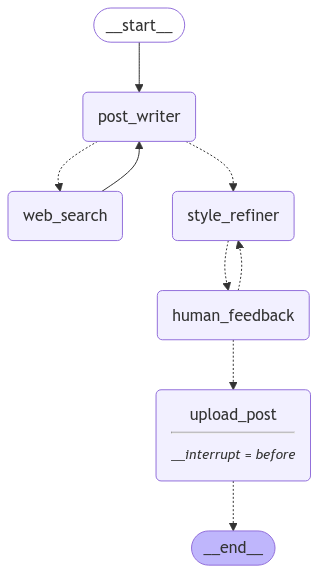

In [149]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from typing import TypedDict, Annotated
from IPython.display import Image, display

# Build graph
builder = StateGraph(LinkedInGraphState)

builder.add_node("post_writer", post_writer)
builder.add_node("web_search", ToolNode([tavily_tool]))
builder.add_node("style_refiner", style_refiner)
builder.add_node("human_feedback", human_feedback)
builder.add_node("upload_post", upload_post)

builder.add_edge(START, "post_writer")
builder.add_edge("web_search", "post_writer")


checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer, interrupt_before=["upload_post"])

## Display graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [160]:
config = {"configurable": {"thread_id": "123"}}

for event in graph.stream(
    {"messages": HumanMessage(content="Write a post about Qwen 2.5 Max")},
    config = config
):
    print(event)

{'post_writer': {'post': 'invoking llm...'}}
{'style_refiner': {'post': 'invoking llm...'}}
{'__interrupt__': (Interrupt(value={'post': 'invoking llm...', 'is_approved': 'Is the post acceptable? [y/n]: '}, resumable=True, ns=['human_feedback:5b325e82-d20c-5f3a-2382-114e6b1e99cd'], when='during'),)}


In [161]:
for event in graph.stream(
    Command(resume="n"), config
):
    print(event)

{'__interrupt__': (Interrupt(value='Please provide feedback about the post: ', resumable=True, ns=['human_feedback:5b325e82-d20c-5f3a-2382-114e6b1e99cd'], when='during'),)}


In [162]:
for event in graph.stream(
    Command(resume="Use simple words"), config
):
    print(event)

{'human_feedback': {'is_acceptable': 'no', 'user_feedback': 'Use simple words'}}
{'style_refiner': {'post': 'invoking llm...'}}
{'__interrupt__': (Interrupt(value={'post': 'invoking llm...', 'is_approved': 'Is the post acceptable? [y/n]: '}, resumable=True, ns=['human_feedback:1c01bbbc-1e95-0158-b2fe-0d90e6b7fc90'], when='during'),)}


In [163]:
for event in graph.stream(
    Command(resume="y"), config
):
    print(event)

{'human_feedback': {'is_acceptable': 'yes'}}
{'__interrupt__': ()}


In [164]:
for event in graph.stream(
    None, config  ## Resume from the upload_post
):
    print(event)

{'upload_post': {'messages': [HumanMessage(content='The post has successfully been posted!', additional_kwargs={}, response_metadata={}, id='ec61b897-d2e1-413a-aadd-e30764c1f9a5')]}}
